In [1]:
import numpy as np
from mitgcmdata import MITgcmmodel, layers, budgets
from jmd95 import eos
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
ddir = '/data/scratch/rpa/SOSE/run_matt'
m = MITgcmmodel.ModelInstance(output_dir=ddir, default_iter=480)


2160 320  42


/home/rpa/mitgcmdata/mitgcmdata/MITgcmmodel.py:60: RuntimeWarning: divide by zero encountered in reciprocal
  (self.rac * self.drf * self.hFacC)**-1, 0.)


In [3]:
rholevs = np.load('../data/rholevs.npy')
wmt = np.load('../data/wmt_full_depth.npz')
wmt_salt_o = wmt['wmt_salt']
wmt_heat_o = wmt['wmt_heat'] # includes sw as a separate component

wmt_heat = wmt_heat_o[:,np.r_[0,1,2,3,4,6,7]].copy() # reorder to have same order as salt
wmt_heat[:,0] += wmt_heat_o[:,5]

labels_salt_o = ['surfflux', 'linfs', 'adv', 'hdiff', 'kpp', 'tot', 'vdiff']
labels_heat_o = ['surfflux', 'linfs', 'adv', 'kpp', 'vdiff', 'sw', 'tot', 'hdiff']

# reorder labels
labels_salt = ['surfflux', 'linfs', 'adv', 'hdiff', 'vdiff', 'kpp', 'tot']
wmt_salt = wmt_salt_o[:,np.r_[0,1,2,3,6,4,5]].copy() # reorder to have same order as salt

labels_heat = ['surfflux', 'linfs', 'adv', 'hdiff', 'vdiff', 'kpp', 'tot']
wmt_heat = wmt_heat_o[:,np.r_[0,1,2,7,4,3,6]].copy() 
wmt_heat[:,0] += wmt_heat_o[:,5] # add sw

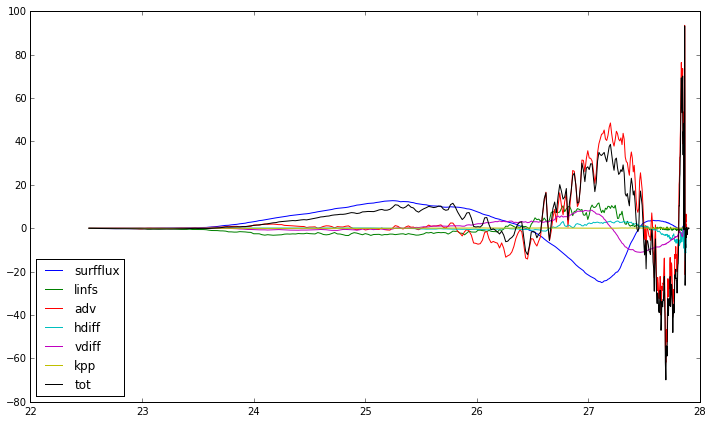

In [4]:
rl = rholevs[1:]-1000.

plt.rcParams['figure.figsize'] = (12,7)
plt.plot(rl, wmt_salt.mean(axis=0).T/1e6)
plt.legend(labels_salt, loc='lower left')

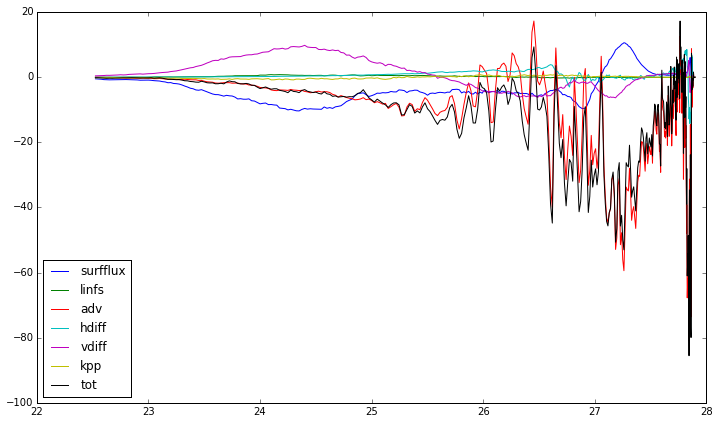

In [5]:
plt.plot(rl, wmt_heat.mean(axis=0).T/1e6)
plt.legend(labels_heat, loc='lower left')

# Read Layers Input #

In [6]:
def process_layers(ddir, iter0, diters, N, deltaTclock=900, layers_name='1RHO'):

    iters = range(iter0,iter0+N*diters,diters)
    DT = diters * deltaTclock
    m = MITgcmmodel.ModelInstance(ddir, default_iter=list(iters))


    layers_transport = m.rdmds('DiagLAYERS-transport', iters[1:]).mean(axis=0)
    uh, vh = layers_transport[0], layers_transport[3]
    hw, hs = layers_transport[1,::-1], layers_transport[4,::-1]
    pi_s = layers_transport[5,::-1]
    
    layers_diapycnal = m.rdmds('DiagLAYERS-diapycnal', iters[1:]).mean(axis=0)
    layers_trend = m.rdmds('DiagLAYERS-trend', iters)

    # process data
    la = layers.LayersAnalyzer(m, layers_name=layers_name)
    dvol_dt = la.volume_trend(layers_trend[np.r_[0,-1]], DT*(N-1))
    #dvol_dt = la.volume_trend(layers_trend, DT)
    #if dvol_dt.ndim == 4:
    #    # average over time
    #    dvol_dt = dvol_dt.mean(axis=0)

    # everything but the advective tendencies
    diapycnal_vel = la.diapycnal_velocity(layers_diapycnal[np.r_[:3,5:8]])

    advective_vel = la.advective_flux_divergence(uh, vh)
    
    # "direct" form of advective vel
    advective_vel_direct = la.diapycnal_velocity(layers_diapycnal[np.r_[3,4,8,9]]).sum(axis=0)
    
    # "TOTTEND"
    diapycnal_vel_tottend = -la.diapycnal_velocity(layers_diapycnal[np.r_[10,11]]/(24*60*60)).sum(axis=0)
    
    diapycnal_vel_numerical = dvol_dt - diapycnal_vel.sum(axis=0) - advective_vel
    diapycnal_vel_numerical_direct = dvol_dt - diapycnal_vel.sum(axis=0) - advective_vel_direct

    
    psi = la.calculate_moc(vh) / 1e6
    print psi.shape

    # something is wrong with this
    pi = pi_s.mean(axis=-1)
    
    return {'dvol_dt': dvol_dt,
            'diapycnal_vel': diapycnal_vel,
            'advective_vel': advective_vel,
            'advective_vel_direct': advective_vel_direct,
            'diapycnal_vel_numerical': diapycnal_vel_numerical,
            'diapycnal_vel_tottend': diapycnal_vel_tottend,
            'diapycnal_vel_numerical_direct': diapycnal_vel_numerical_direct,
            'uh': uh, 'vh': vh, 'hs': hs, 'hw': hw,
            'psi': psi, 'pi': pi, 'la': la, 'm': m}

In [7]:
ddir = '/data/scratch/rpa/SOSE/run_matt_layers_fgf01'
N = 7


iter0 = 0
#diters= 480
diters=35040
deltaTclock = 900
layers_name = '1RHO'

d = process_layers(ddir, iter0, diters, N, deltaTclock, layers_name)

2160 320  42
(69, 320)


In [20]:
d.keys()

['psi',
 'vh',
 'hs',
 'hw',
 'm',
 'diapycnal_vel_tottend',
 'pi',
 'dvol_dt',
 'la',
 'diapycnal_vel_numerical',
 'advective_vel',
 'diapycnal_vel_numerical_direct',
 'uh',
 'diapycnal_vel',
 'advective_vel_direct']

In [21]:
d['diapycnal_vel'].shape

(6, 68, 320, 2160)

In [67]:
dvel = (d['diapycnal_vel']).sum(axis=-1).sum(axis=-1)
dvel_num = (d['diapycnal_vel_numerical']).sum(axis=-1).sum(axis=-1)
dvel_leg = ['Ts', 'Th', 'Tr', 'Ss', 'Sh', 'Sr']

In [9]:
lb = la.layers_bounds - 1000.
lbw = la.layers_bounds_w - 1000.
print lbw.shape
print dvel.shape
print dvel_num.shape


NameError: name 'la' is not defined

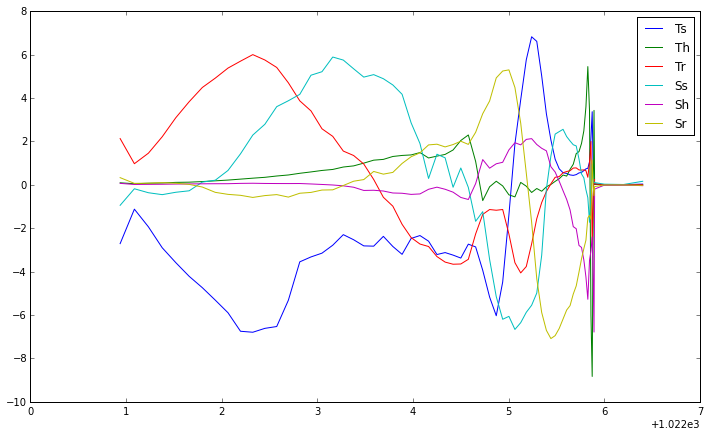

In [39]:
plt.plot(lbw[1:], dvel.T/1e6)
plt.legend(dvel_leg)

## Direct Comparisons ##

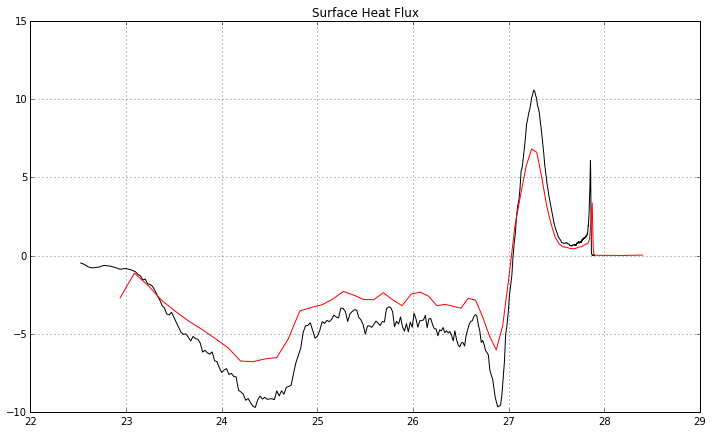

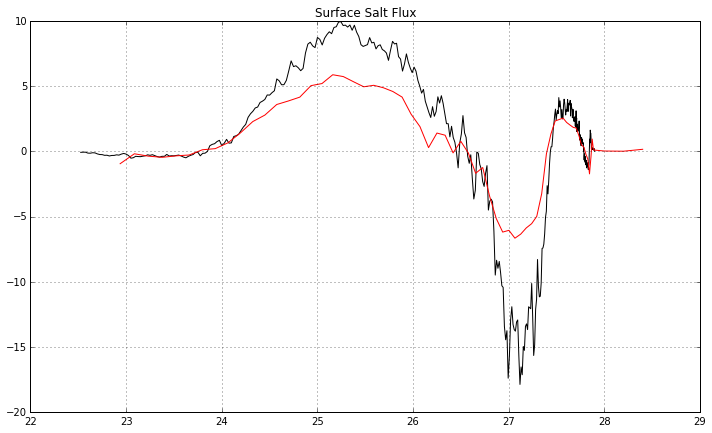

In [59]:

plt.plot(rl, wmt_heat.mean(axis=0)[:2].sum(axis=0).T/1e6, 'k')
plt.plot(lbw[1:], dvel[0]/1e6, 'r')
plt.grid()
plt.title('Surface Heat Flux')

plt.figure()
plt.plot(rl, wmt_salt.mean(axis=0)[:2].sum(axis=0).T/1e6, 'k')
plt.plot(lbw[1:], dvel[3]/1e6, 'r')
plt.grid()
plt.title('Surface Salt Flux')


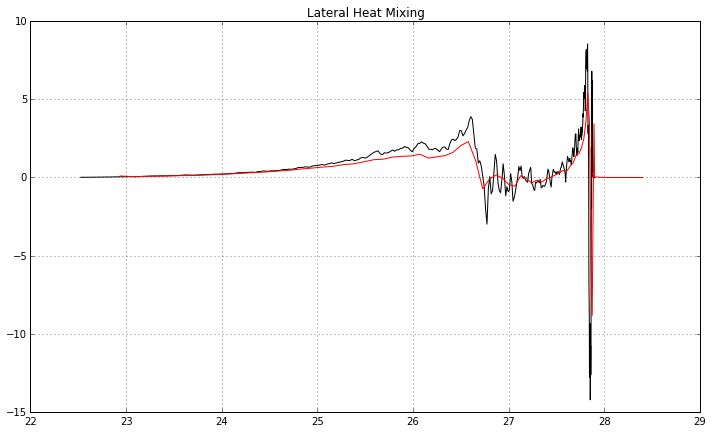

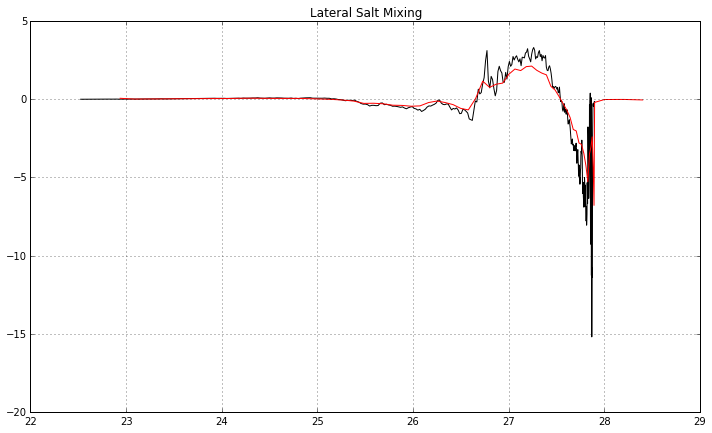

In [61]:
plt.plot(rl, wmt_heat.mean(axis=0)[3]/1e6, 'k')
plt.plot(lbw[1:], dvel[1]/1e6, 'r')
plt.grid()
plt.title('Lateral Heat Mixing')

plt.figure()
plt.plot(rl, wmt_salt.mean(axis=0)[3]/1e6, 'k')
plt.plot(lbw[1:], dvel[4]/1e6, 'r')
plt.grid()
plt.title('Lateral Salt Mixing')


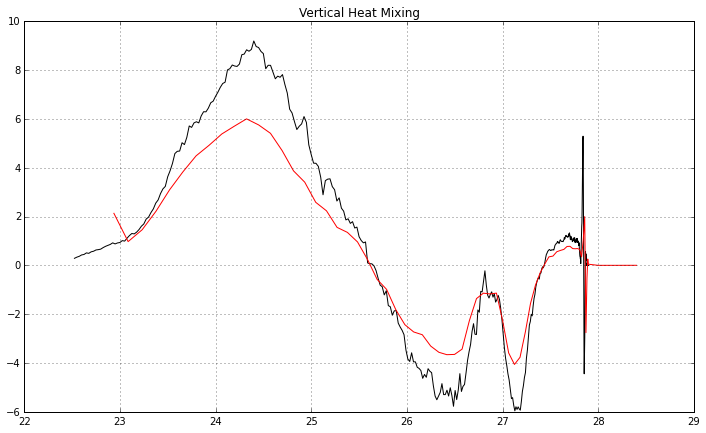

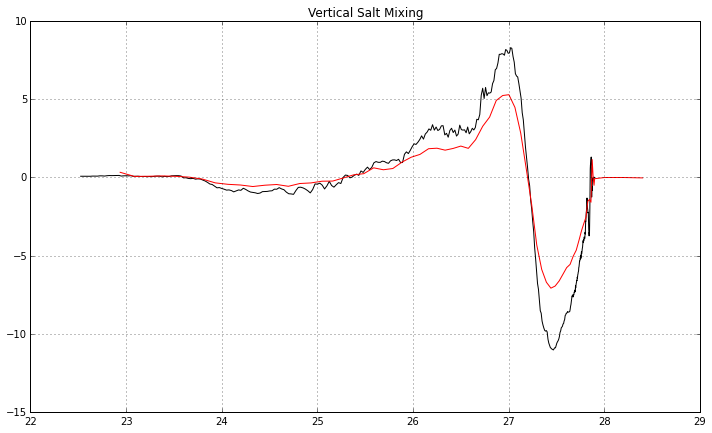

In [63]:
plt.plot(rl, wmt_heat.mean(axis=0)[4:6].sum(axis=0)/1e6, 'k')
plt.plot(lbw[1:], dvel[2]/1e6, 'r')
plt.grid()
plt.title('Vertical Heat Mixing')

plt.figure()
plt.plot(rl, wmt_salt.mean(axis=0)[4:6].sum(axis=0)/1e6, 'k')
plt.plot(lbw[1:], dvel[5]/1e6, 'r')
plt.grid()
plt.title('Vertical Salt Mixing')

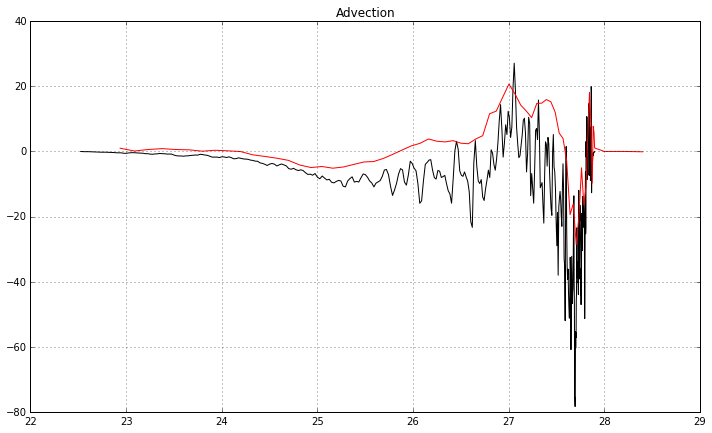

In [69]:
plt.plot(rl, (wmt_heat.mean(axis=0)[2] + wmt_salt.mean(axis=0)[2])/1e6, 'k')
plt.plot(lbw[1:], dvel_num/1e6, 'r')
plt.grid()
plt.title('Advection')


In [70]:
rholevs

array([ 1022.5       ,  1022.525     ,  1022.55      ,  1022.575     ,
        1022.6       ,  1022.625     ,  1022.65      ,  1022.675     ,
        1022.7       ,  1022.725     ,  1022.75      ,  1022.775     ,
        1022.8       ,  1022.825     ,  1022.85      ,  1022.875     ,
        1022.9       ,  1022.925     ,  1022.95      ,  1022.975     ,
        1023.        ,  1023.025     ,  1023.05      ,  1023.075     ,
        1023.1       ,  1023.125     ,  1023.15      ,  1023.175     ,
        1023.2       ,  1023.225     ,  1023.25      ,  1023.275     ,
        1023.3       ,  1023.325     ,  1023.35      ,  1023.375     ,
        1023.4       ,  1023.425     ,  1023.45      ,  1023.475     ,
        1023.5       ,  1023.525     ,  1023.55      ,  1023.575     ,
        1023.6       ,  1023.625     ,  1023.65      ,  1023.675     ,
        1023.7       ,  1023.725     ,  1023.75      ,  1023.775     ,
        1023.8       ,  1023.825     ,  1023.85      ,  1023.875     ,
      

In [71]:
len(rholevs)

400

In [10]:
lb

NameError: name 'lb' is not defined

In [15]:
d['la'].layers_bounds[::-1] - 1000

array([ 22.86248779,  23.01251221,  23.16021729,  23.3057251 ,
        23.44891357,  23.58984375,  23.72851562,  23.8649292 ,
        23.99908447,  24.13098145,  24.26049805,  24.38793945,
        24.51293945,  24.63574219,  24.75634766,  24.87463379,
        24.99060059,  25.10437012,  25.21582031,  25.32507324,
        25.43200684,  25.53674316,  25.63916016,  25.73925781,
        25.8371582 ,  25.93286133,  26.02612305,  26.11730957,
        26.20605469,  26.29260254,  26.37695312,  26.45898438,
        26.53869629,  26.61621094,  26.69152832,  26.7644043 ,
        26.83520508,  26.90356445,  26.96972656,  27.03369141,
        27.09533691,  27.15466309,  27.21179199,  27.26660156,
        27.31921387,  27.36950684,  27.41760254,  27.46337891,
        27.50683594,  27.5480957 ,  27.5871582 ,  27.6237793 ,
        27.6583252 ,  27.69042969,  27.72033691,  27.74804688,
        27.7734375 ,  27.79650879,  27.81738281,  27.83605957,
        27.85229492,  27.86645508,  27.87817383,  27.88